In [1]:
#class 24

import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization

#pandas deprecated. Se utilizar import pandas_datareader.data as web dá erro

#se não utilizar --user tem erro de permissão do usuário
!pip install pip --upgrade --user
!pip install pandas-datareader --user
import pandas_datareader.data as web


#yahoo deprecated. Usando essa entrada para consertar
!pip install yfinance --user
!pip install yfinance --upgrade --user

In [2]:
#these are the stocks we can choose in our portfolio, but you can pick others
stocks = ['AAPL','WMT','TSLA','GE','AMZN','DB']

#we use historical data to approximate mean and variance: MPT depends on historical data !!!
start_date='01/01/2010'
end_date ='01/01/2021'

#downloading the data from Yahoo! Finance e...criando as funções apenas
def download_data(stocks):
	data = web.DataReader(stocks,data_source='yahoo',start=start_date,end=end_date)['Adj Close']
	data.columns = stocks
	return data
	
def show_data(data):
	data.plot(figsize=(10,5))
	plt.show()


In [3]:
#we usually use natural logarithm for normalization purposes
def calculate_returns(data):
	returns = np.log(data/data.shift(1))
	return returns;
	
def plot_daily_returns(returns):
	returns.plot(figsize=(10,5))
	plt.show()

#print out mean and covariance of stocks within [start_date, end_date]. There are 252 trading days within a year
def show_statistics(returns):
	print(returns.mean()*252)
	print(returns.cov()*252)

#weights defines what stocks to include (with what portion) in the portfolio
def initialize_weights():
	weights = np.random.random(len(stocks))
	weights /= np.sum(weights)
	return weights;
	

In [4]:
#class 25

#expected portfolio return
def calculate_portfolio_return(returns, weights):
	portfolio_return = np.sum(returns.mean()*weights)*252
	print("Expected portfolio return:", portfolio_return)

#expected portfolio variance
def calculate_portfolio_variance(returns, weights):
	portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
	print("Expected variance:", portfolio_variance)


In [5]:
#class 26

def generate_portfolios(weights, returns):

	preturns = []
	pvariances = []

	#Monte-Carlo simulation: we generate several random weights -> so random portfolios !!!
	for i in range(100000):
		weights = np.random.random(len(stocks))
		weights/=np.sum(weights)
		preturns.append(np.sum(returns.mean()*weights)*252)
		pvariances.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights))))
	
	preturns = np.array(preturns)
	pvariances = np.array(pvariances)
	return preturns,pvariances

def plot_portfolios(returns, variances):
	plt.figure(figsize=(10,6))
	plt.scatter(variances,returns,c=returns/variances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.show()


In [6]:
#class 27

# OK this is the result of the simulation ... we have to find the optimal portfolio with 
# some optimization technique !!! scipy can optimize functions (minimum/maximum finding)
def statistics(weights, returns):
	portfolio_return=np.sum(returns.mean()*weights)*252
	portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
	return np.array([portfolio_return,portfolio_volatility,portfolio_return/portfolio_volatility])

# [2] means that we want to maximize according to the Sharpe-ration....portfolio_return/portfolio_volatility na equação acima
# note: maximizing f(x) function is the same as minimizing -f(x) !!!
def	min_func_sharpe(weights,returns):
	return	-statistics(weights,returns)[2] 
	
# what are the constraints? The sum of weights = 1 !!!  f(x)=0 this is the function to minimize
def optimize_portfolio(weights,returns):
	constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #the sum of weights is 1
	bounds = tuple((0,1) for x in range(len(stocks))) #the weights can be 1 at most: 1 when 100% of money is invested into a single stock
	optimum=optimization.minimize(fun=min_func_sharpe,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
	return optimum
	
# optimal portfolio according to weights: 0 means no shares of that given company 
def print_optimal_portfolio(optimum, returns):
	print("Optimal weights:", optimum['x'].round(3))
	print("Expected return, volatility and Sharpe ratio:", statistics(optimum['x'].round(3),returns))

def show_optimal_portfolio(optimum, returns, preturns, pvariances):
	plt.figure(figsize=(10,6))
	plt.scatter(pvariances,preturns,c=preturns/pvariances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.plot(statistics(optimum['x'],returns)[1],statistics(optimum['x'],returns)[0],'g*',markersize=20.0)
	plt.show()
	


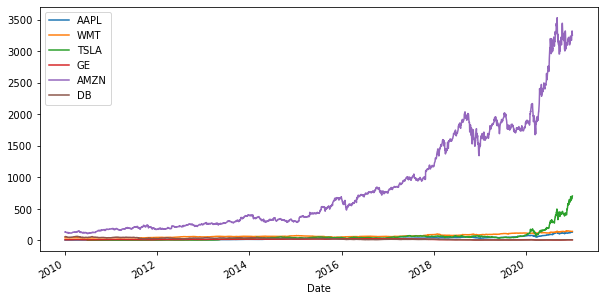

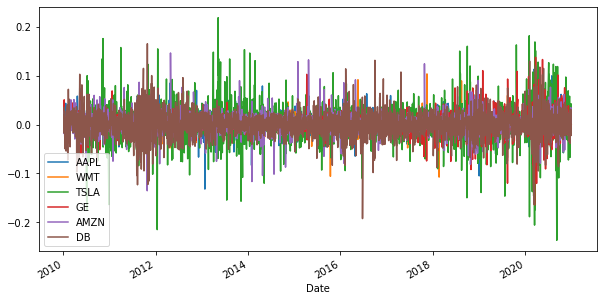

AAPL    0.273298
WMT     0.113584
TSLA    0.475726
GE     -0.000255
AMZN    0.290551
DB     -0.153805
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.080272  0.016285  0.048835  0.031170  0.040301  0.042428
WMT   0.016285  0.035864  0.015407  0.013979  0.014837  0.018980
TSLA  0.048835  0.015407  0.314517  0.039773  0.056369  0.059723
GE    0.031170  0.013979  0.039773  0.099874  0.026494  0.065912
AMZN  0.040301  0.014837  0.056369  0.026494  0.100060  0.042272
DB    0.042428  0.018980  0.059723  0.065912  0.042272  0.175235
Expected portfolio return: 0.21391965298928953
Expected variance: 0.21625436408617574


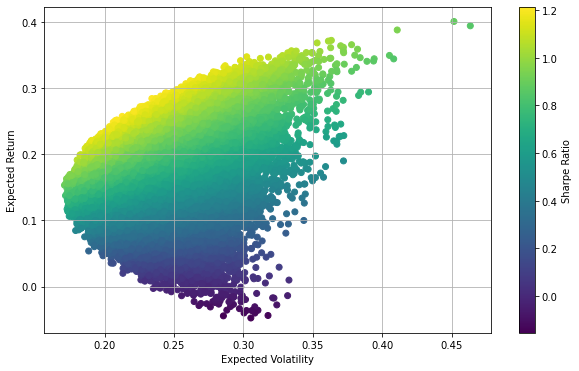

Optimal weights: [0.335 0.241 0.162 0.    0.262 0.   ]
Expected return, volatility and Sharpe ratio: [0.27212058 0.22154192 1.22830289]


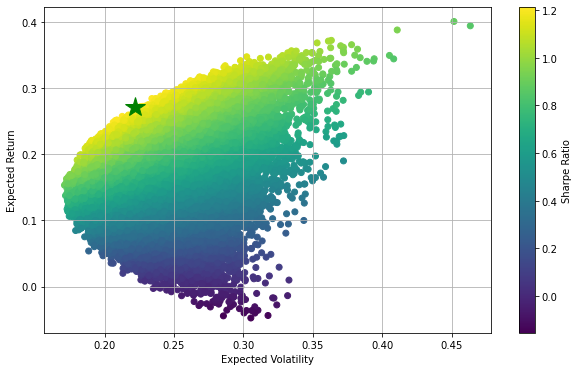

In [7]:
#process everything above 

if __name__ == "__main__":
	data = download_data(stocks)
	show_data(data)
	returns = calculate_returns(data)
	plot_daily_returns(returns)
	show_statistics(returns)
	weights=initialize_weights()
	calculate_portfolio_return(returns,weights)
	calculate_portfolio_variance(returns,weights)
	preturns,pvariances=generate_portfolios(weights, returns)
	plot_portfolios(preturns,pvariances)
	optimum=optimize_portfolio(weights,returns)
	print_optimal_portfolio(optimum, returns)
	show_optimal_portfolio(optimum, returns, preturns, pvariances)
	